# Cough Classification with KNN and SVM Models

This notebook includes classification of cough based on KNN and SVM models. The features used to train model are mfccs and percentiles. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy
import os
from IPython.display import Audio
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
import bisect
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.fftpack import dct
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import scale

# Data Preparation

## Data Loading

In [3]:
# Extracts timestamps from a .txt file
# Each line in the file contains a start and finish time separated by a tab.

def get_real_timestamps(audio_timestamp_file):
    
    """
    Parses a .txt file containing timestamp information.
    
    Parameters:
        audio_timestamp_file (str): Path to the .txt file.
    
    Returns:
        list: List of tuples, each containing start and finish times.
    """
    
    timestamps = []

    with open(audio_timestamp_file, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                start, end = map(float, line.split("\t"))
                timestamps.append((start, end))

    return timestamps

In [4]:
# Function to load audio data along with corresponding timestamps and labels.
def load_data(audio_dir, timestamp_dir, label, sr=48000):
    
    """
    Loads audio data from WAV files along with corresponding timestamps and labels.

    Parameters:
        audio_dir (str): Directory containing audio WAV files.
        timestamp_dir (str): Directory containing timestamp text files.
        label (str): Label to assign to the loaded data.
        sr (int): Sample rate of the audio files (default is 48000).

    Returns:
        tuple: A tuple containing lists of loaded audio data, timestamps, and labels.
    """
    
    audio_files = [file for file in os.listdir(audio_dir) if file.endswith('.wav')]
    timestamp_files = [file for file in os.listdir(timestamp_dir) if file.endswith('.txt')]
    
    
    audios = []
    timestamps = []
    labels = []
    
    for audio_file in audio_files:
    
        try:
            
            base_name = os.path.splitext(audio_file)[0]
            timestamp_file = base_name + '-label.txt'
            
            if timestamp_file not in timestamp_files:
                raise ValueError(f"No corresponding timestamp file found for {audio_file}")
                
            audio_path = os.path.join(audio_dir, audio_file)
            timestamp_path = os.path.join(timestamp_dir, timestamp_file)
            
            # Adding timestamps to the list
            real_timestamps = get_real_timestamps(timestamp_path)

            # Loading audio file
            data, sample_rate = librosa.load(audio_path, sr=sr, mono=True)
            data = librosa.resample(data, orig_sr=sample_rate, target_sr=sr)

            audios.append(data)
            timestamps.append(real_timestamps)
            labels.append(label)

        except Exception as e:
            print(f"Error processing {audio_file}: {e}")
            continue

    
    return audios, timestamps, labels

In [5]:
# Initialize an empty dictionary to store audio data along with timestamps and labels
audio_data = {'audio': [], 'timestamps': [], 'label': []}

# Define the sample rate for the audio data
sample_rate = 48000

# Load cough and non-cough audio data along with their timestamps and labels
cough_data, cough_timestamps, cough_labels = load_data('../recordings-and-timestamps/audio-recordings/cough-recordings/', '../recordings-and-timestamps/audio-timestamps/cough-timestamps/', 'cough')
other_data, other_timestamps, other_labels = load_data('../recordings-and-timestamps/audio-recordings/other-recordings/', '../recordings-and-timestamps/audio-timestamps/other-timestamps/', 'other')
cough_data_internet, cough_timestamps_internet, cough_labels_internet = load_data('../recordings-and-timestamps/audio-recordings/cough-recordings-internet/', '../recordings-and-timestamps/audio-timestamps/cough-timestamps-internet/', 'cough')
other_data_internet, other_timestamps_internet, other_labels_internet = load_data('../recordings-and-timestamps/audio-recordings/other-recordings-internet/', '../recordings-and-timestamps/audio-timestamps/other-timestamps-internet/', 'other')

# Append own data (cough and non-cough) to the audio_data dictionary
audio_data['audio'].extend(cough_data + other_data)
audio_data['timestamps'].extend(cough_timestamps + other_timestamps)
audio_data['label'].extend(cough_labels + other_labels)

# Append data from the internet (cough and non-cough) to the audio_data dictionary
audio_data['audio'].extend(cough_data_internet + other_data_internet)
audio_data['timestamps'].extend(cough_timestamps_internet + other_timestamps_internet)
audio_data['label'].extend(cough_labels_internet + other_labels_internet)

## Data Splitting

In [6]:
# Splitting the dataset into cough and other categories for classification.
df_init = pd.DataFrame.from_dict(audio_data)

X = df_init.iloc[:,:-1]
y = df_init.iloc[:, -1]

# Splitting cough data into train and test sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, random_state=3, train_size=0.70)

## Data Normalization and Filtering

### Preprocessing Functions

In [7]:
# This function designs a Butterworth bandpass filter and applies it to the input data.

def butter_bandpass(lowcut, highcut, fs, order=8):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):

    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

In [8]:
# Function to normalize the given data

def normalize_data(data):

    # Find the minimum and maximum values in the data
    data_min = np.min(data)
    data_max = np.max(data)

    # Normalize the data using min-max scaling
    normalized_data = (data - data_min) / (data_max - data_min)

    return normalized_data

In [9]:
def compute_moving_average(data, window_size=15):

    """
    Computes the moving average of the input data using a specified window size.

    Parameters:
    - data (array-like): Input data to compute the moving average.
    - window_size (int, optional): Size of the moving average window. Defaults to 15.

    Returns:
    - array: Array containing the moving averages.

    Note:
    The moving average is computed using a simple convolution with a kernel of ones.
    """
    kernel = np.ones(window_size) / window_size
    moving_averages = np.convolve(data, kernel, mode='valid')
    moving_averages = np.round(moving_averages, 2)
    
    return moving_averages

In [10]:
# Preprocesses the input data by applying a bandpass filter, computing moving average, and normalizing the data.
def preprocess_data(data):
    
    """
    Parameters:
    - data (ndarray): Input data to be preprocessed.
        
    Returns:
    - ndarray: Preprocessed data.

    Note:
    - This function applies a bandpass filter, computes the moving average, and normalizes the data.
    """

    # Apply bandpass filter to remove unwanted frequencies
    filtered_data = butter_bandpass_filter(data, lowcut=1000, highcut=4000, fs=sample_rate, order=8)

    # Compute moving average of the absolute values of the filtered data
    averaged_data = compute_moving_average(np.abs(filtered_data))

    # Normalize the data
    normalized_data = normalize_data(averaged_data)

    # Flatten the data
    flattened_data = normalized_data.flatten()

    return flattened_data

### Percentile Calculation Functions

In [11]:
def find_percentile_points(signal):
    
        """
        Calculate the percentile points (25th, 50th, 75th, and 90th percentiles) of a signal using Fast Fourier Transform (FFT).

        Parameters:
        - signal (array_like): The input signal.
        - sample_rate (float): The sampling rate of the signal.

        Returns:
        - tuple: A tuple containing the percentile points (25th, 50th, 75th, and 90th percentiles).
        
        """
        
        # Calculate Fast Fourier Transform
        X = np.fft.fft(signal)
        X_mag = np.abs(X) / len(signal)
        freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

        # Consider only positive frequencies
        positive_freq_indices = np.where(freqs >= 0)
        freqs = freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]

        # Calculate area under curve
        auc = simps(X_mag, freqs)

        # Define percentiles
        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Calculate cumulative area
        cumulative_auc = np.cumsum(X_mag)

        # Find indices for each percentile
        point_1 = np.argmax(cumulative_auc >= per_25)
        point_2 = np.argmax(cumulative_auc >= per_50)
        point_3 = np.argmax(cumulative_auc >= per_75)
        point_4 = np.argmax(cumulative_auc >= per_90)

        # Retrieve frequency points corresponding to percentiles
        per_25_result = freqs[point_1]
        per_50_result = freqs[point_2]
        per_75_result = freqs[point_3]
        per_90_result = freqs[point_4]

        return per_25_result, per_50_result, per_75_result, per_90_result

### MFCC Calculation Functions

In [12]:
def get_mfcc_features(signal, sample_rate=48000, n_mfcc=13, delta_width=3):
    
    # Original MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

    # First derivative of MFCCs
    delta_mfccs = librosa.feature.delta(mfccs, width=delta_width)

    # Second derivative of MFCCs
    delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=delta_width)

    return mfccs, delta_mfccs, delta2_mfccs

## Extracting Data Features

In [13]:
# Function to remove leading and trailing zeros from a float array

def remove_leading_trailing_zeros(array):
    
    nonzero_indices = np.where(array != 0)[0]
    if len(nonzero_indices) == 0:
        return np.array([])
    
    return array[nonzero_indices[0]:nonzero_indices[-1] + 1]

### Train Data Feature Extraction

In [14]:
# Extract Train Data

# Initialize extracted train data dictionary
extracted_train_data = {'data': [], 'label': []}

# Iterate through train data and labels
for (info, label) in zip(X_train_raw.values, y_train_raw.values):
    
    # Extract features and timestamps
    data, timestamps = info[0], info[1]
    data = remove_leading_trailing_zeros(data)

    # Preprocess data
    data = preprocess_data(data)
    
    # Extract coughs/others
    for timestamp in timestamps:
        
        start = int(timestamp[0] * sample_rate)
        finish = int(timestamp[1] * sample_rate)
        
        # Ensure start and finish are within bounds
        start = max(0, start)
        finish = min(len(data), finish)

        # Extract data within timestamps
        extracted_data = data[start:finish]
        
        # Append extracted data and label
        if len(extracted_data) > 0:
            extracted_train_data['data'].append(extracted_data)
            extracted_train_data['label'].append(label)
        
# Convert dictionary to DataFrame
df_train_extracted = pd.DataFrame.from_dict(extracted_train_data)
print(df_train_extracted)

                                                  data  label
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  cough
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  cough
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  cough
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  cough
4    [0.4054054054054054, 0.4054054054054054, 0.405...  cough
..                                                 ...    ...
635  [0.26666666666666666, 0.26666666666666666, 0.2...  other
636  [0.4, 0.46666666666666673, 0.4, 0.4, 0.4, 0.33...  other
637  [0.7333333333333334, 0.6666666666666667, 0.6, ...  other
638  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...  other
639  [0.4, 0.4, 0.4, 0.4, 0.33333333333333337, 0.33...  other

[640 rows x 2 columns]


In [15]:
# Dictionary for training data      

Audiodata_train = {'per_25': [], 'per_50': [], 'per_75': [], 'per_90': [], 'label': []}
Audiodata_train_mfcc = {'mfcc': [], 'label': []}
Audiodata_train_combined = {'per_25': [], 'per_50': [], 'per_75': [], 'per_90': [], 'mfcc': [], 'label': []}

In [16]:
for data, label in df_train_extracted.values:
    
    per_25, per_50, per_75, per_90 = find_percentile_points(data)

    mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(extracted_data)  # MFCC features
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))  # Comprehensive MFCCs    
    comprehensive_mfccs_mean = np.mean(comprehensive_mfccs, axis=1)  # Mean of MFCC features

    Audiodata_train['per_25'].append(per_25)
    Audiodata_train['per_50'].append(per_50)
    Audiodata_train['per_75'].append(per_75)
    Audiodata_train['per_90'].append(per_90)
    Audiodata_train['label'].append(label)
    
    Audiodata_train_mfcc['mfcc'].append(comprehensive_mfccs_mean)
    Audiodata_train_mfcc['label'].append(label)
    
    Audiodata_train_combined['per_25'].append(per_25)
    Audiodata_train_combined['per_50'].append(per_50)
    Audiodata_train_combined['per_75'].append(per_75)
    Audiodata_train_combined['per_90'].append(per_90)    
    Audiodata_train_combined['mfcc'].append(comprehensive_mfccs_mean)
    Audiodata_train_combined['label'].append(label)

### Test Data Feature Extraction

In [17]:
# Extract Validation Data

# Initialize extracted train data dictionary
extracted_test_data = {'data': [], 'label': []}

# Iterate through train data and labels
for (info, label) in zip(X_test_raw.values, y_test_raw.values):
    
    # Extract features and timestamps
    data, timestamps = info[0], info[1]
    data = remove_leading_trailing_zeros(data)

    # Preprocess data
    data = preprocess_data(data)
    
    # Extract coughs/others
    for timestamp in timestamps:
        
        start = int(timestamp[0] * sample_rate)
        finish = int(timestamp[1] * sample_rate)
        
        # Ensure start and finish are within bounds
        start = max(0, start)
        finish = min(len(data), finish)

        # Extract data within timestamps
        extracted_data = data[start:finish]
        
        # Append extracted data and label
        if len(extracted_data) > 0:
            extracted_test_data['data'].append(extracted_data)
            extracted_test_data['label'].append(label)
        
# Convert dictionary to DataFrame
df_test_extracted = pd.DataFrame.from_dict(extracted_test_data)

In [18]:
# Dictionary for training data      

Audiodata_test = {'per_25': [], 'per_50': [], 'per_75': [], 'per_90': [], 'label': []}
Audiodata_test_mfcc = {'mfcc': [], 'label': []}
Audiodata_test_combined = {'per_25': [], 'per_50': [], 'per_75': [], 'per_90': [], 'mfcc': [], 'label': []}

In [19]:
for data, label in df_test_extracted.values:
    
    per_25, per_50, per_75, per_90 = find_percentile_points(data)

    mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(extracted_data)  # MFCC features
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))  # Comprehensive MFCCs    
    comprehensive_mfccs_mean = np.mean(comprehensive_mfccs, axis=1)  # Mean of MFCC features

    Audiodata_test['per_25'].append(per_25)
    Audiodata_test['per_50'].append(per_50)
    Audiodata_test['per_75'].append(per_75)
    Audiodata_test['per_90'].append(per_90)
    Audiodata_test['label'].append(label)
    
    Audiodata_test_mfcc['mfcc'].append(comprehensive_mfccs_mean)
    Audiodata_test_mfcc['label'].append(label)
    
    Audiodata_test_combined['per_25'].append(per_25)
    Audiodata_test_combined['per_50'].append(per_50)
    Audiodata_test_combined['per_75'].append(per_75)
    Audiodata_test_combined['per_90'].append(per_90)
    Audiodata_test_combined['mfcc'].append(comprehensive_mfccs_mean)
    Audiodata_test_combined['label'].append(label)

In [20]:
df_train_per = pd.DataFrame.from_dict(Audiodata_train)
df_train_mfcc = pd.DataFrame.from_dict(Audiodata_train_mfcc)
df_train_combined = pd.DataFrame.from_dict(Audiodata_train_combined)

df_test_per = pd.DataFrame.from_dict(Audiodata_test)
df_test_mfcc = pd.DataFrame.from_dict(Audiodata_test_mfcc)
df_test_combined = pd.DataFrame.from_dict(Audiodata_test_combined)

# Percentile Graphs for Cough and Other Audio

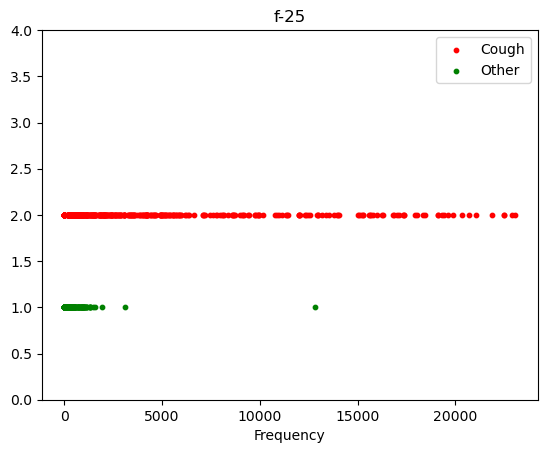

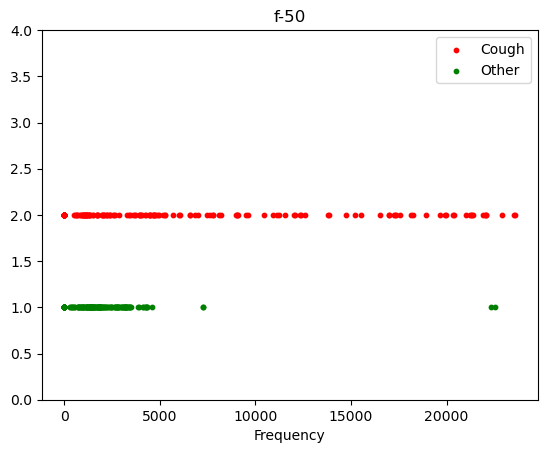

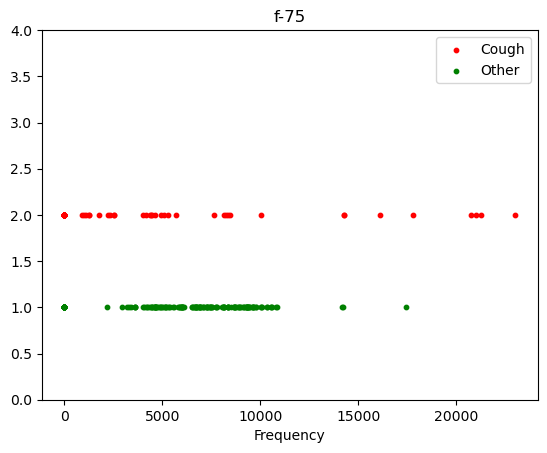

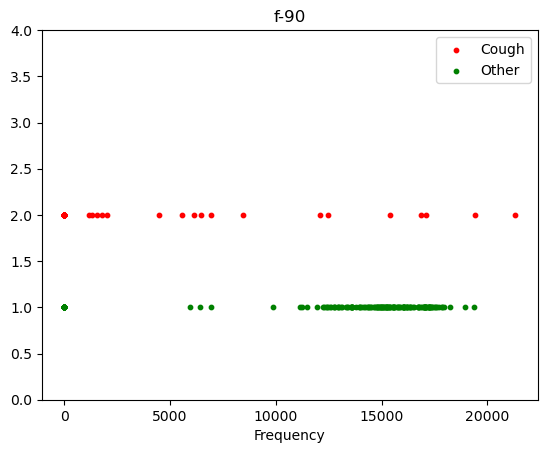

In [21]:
# PLOT OF COUGH AND NO COUGH

# 25 percentile
per_25_data = df_train_per[df_train_per['label'] == 'cough']['per_25']
per_50_data = df_train_per[df_train_per['label'] == 'cough']['per_50']
per_75_data = df_train_per[df_train_per['label'] == 'cough']['per_75']
per_90_data = df_train_per[df_train_per['label'] == 'cough']['per_90']

no_cough_per_25_data = df_train_per[df_train_per['label'] == 'other']['per_25']
no_cough_per_50_data = df_train_per[df_train_per['label'] == 'other']['per_50']
no_cough_per_75_data = df_train_per[df_train_per['label'] == 'other']['per_75']
no_cough_per_90_data = df_train_per[df_train_per['label'] == 'other']['per_90']


# Cough
i = 0
for point in per_25_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point in no_cough_per_25_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-25")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()

# 50 percentile 

# Cough

i = 0
for point in per_50_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
    
# No Cough

i = 0
for point in no_cough_per_50_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)
        
    i += 1
    
    
plt.title("f-50")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()


# 75 percentile

# Cough

i = 0
for point in per_75_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)
        
    i += 1
    

# No Cough

i = 0
for point in no_cough_per_75_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-75")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()
# 90 percentile

# Cough

i = 0
for point in per_90_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough

i = 0
for point in no_cough_per_90_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1
    
plt.title("f-90")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()

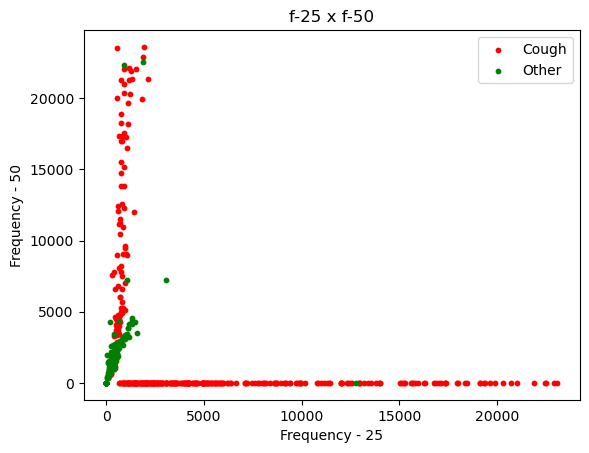

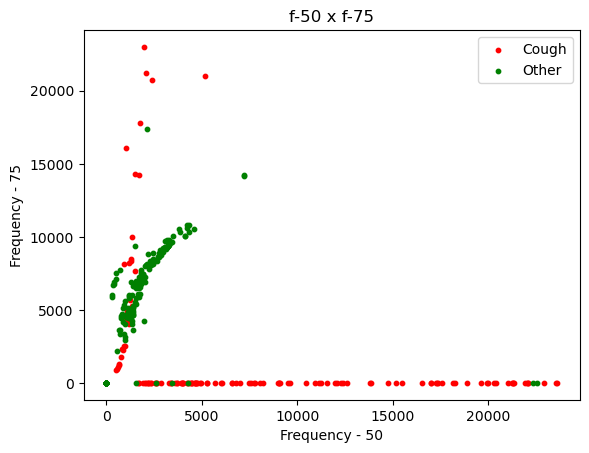

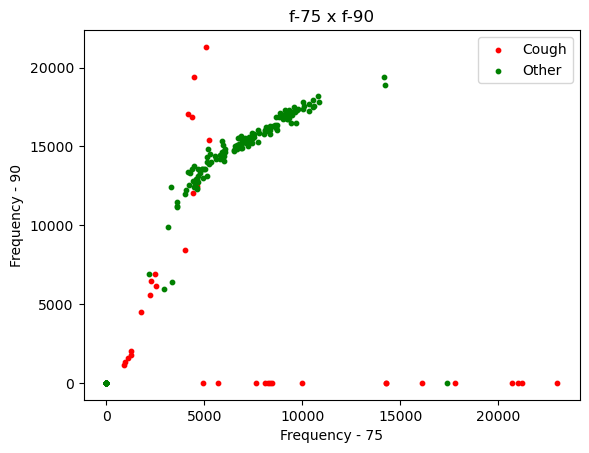

In [22]:
# 2 Dimensional Graphs


# 25 percentile x 50 percentile

# Cough
i = 0
for point1, point2 in zip(per_25_data, per_50_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_25_data, no_cough_per_50_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-25 x f-50")
plt.xlabel("Frequency - 25")
plt.ylabel("Frequency - 50")
plt.legend()
plt.show()


# 50 percentile x 75 percentile

# Cough
i = 0
for point1, point2 in zip(per_50_data, per_75_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_50_data, no_cough_per_75_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-50 x f-75")
plt.xlabel("Frequency - 50")
plt.ylabel("Frequency - 75")
plt.legend()
plt.show()

# 75 percentile x 90 percentile

# Cough
i = 0
for point1, point2 in zip(per_75_data, per_90_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_75_data, no_cough_per_90_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-75 x f-90")
plt.xlabel("Frequency - 75")
plt.ylabel("Frequency - 90")
plt.legend()
plt.show()

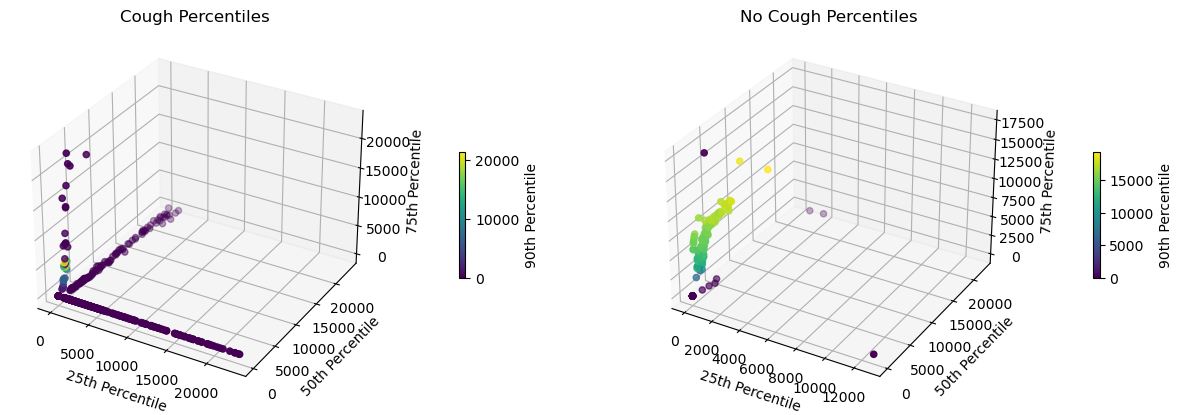

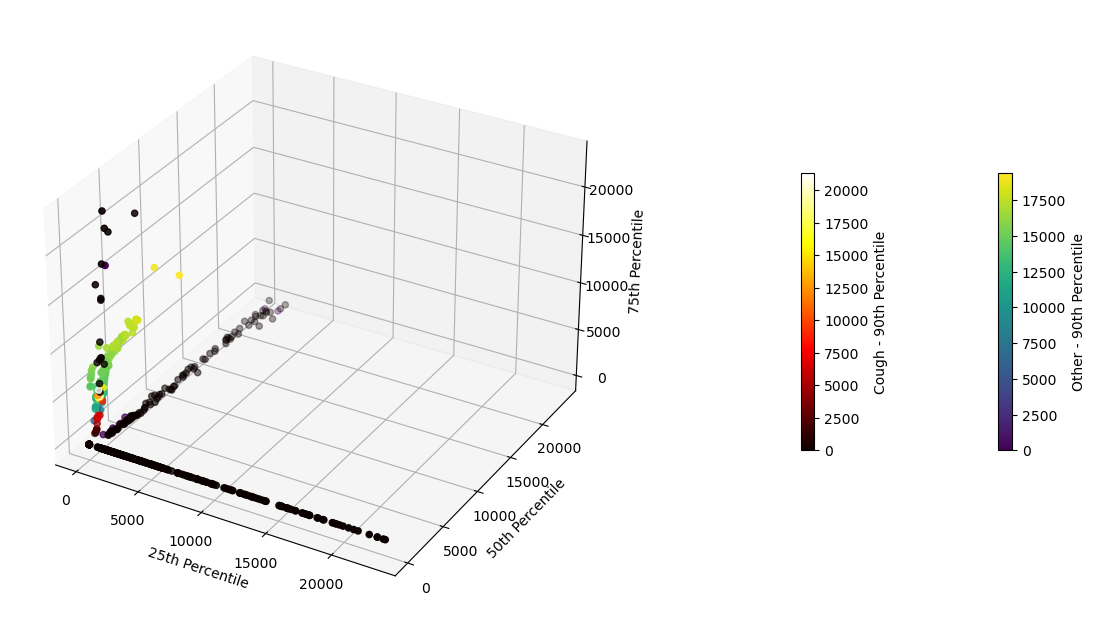

In [23]:
# 4 Dimensional Graph

# Cough Graph
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(221, projection='3d')

img = ax.scatter(per_25_data, per_50_data, per_75_data, c= per_90_data)
ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar = fig.colorbar(img, shrink=0.3, pad=0.15)
colorbar.set_label('90th Percentile')
plt.title("Cough Percentiles")


# No Cough Graph

ax = fig.add_subplot(222, projection='3d')

img = ax.scatter(no_cough_per_25_data, no_cough_per_50_data, no_cough_per_75_data, c= no_cough_per_90_data, cmap='viridis')
ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar.set_label('90th Percentile')
colorbar = fig.colorbar(img, shrink=0.3, pad=0.15)
colorbar.set_label('90th Percentile')
plt.title("No Cough Percentiles")
plt.show()

# Combinations

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

img_1 = ax.scatter(no_cough_per_25_data, no_cough_per_50_data, no_cough_per_75_data, c= no_cough_per_90_data, cmap='viridis')
colorbar_1 = fig.colorbar(img_1, ax=[ax], shrink=0.3)
colorbar_1.set_label('Other - 90th Percentile')


img_2 = ax.scatter(per_25_data, per_50_data, per_75_data, c= per_90_data, cmap=plt.hot())
colorbar_2 = fig.colorbar(img_2, ax=[ax], shrink=0.3, pad=0.20)

ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar_2.set_label('Cough - 90th Percentile')

plt.show()

# K-Nearest Neighbors

## KNN Percentiles

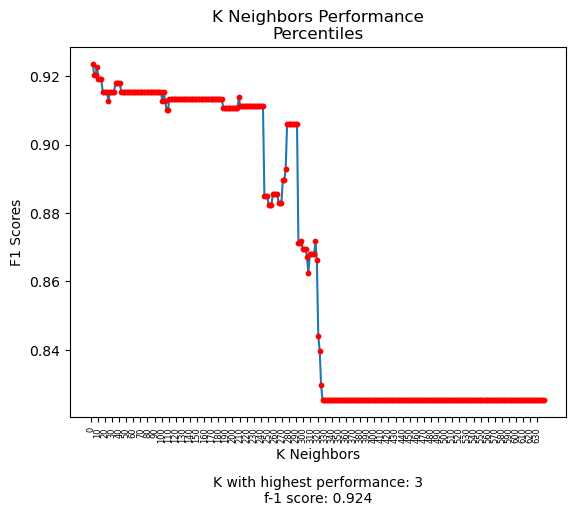


F1_score: 0.924


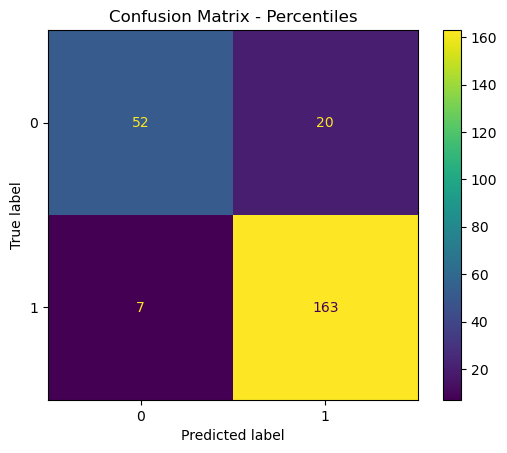

In [34]:
# Create train data

X_train_per = []
y_train_per = []

for row in df_train_per.values:
    
    flattened_row = np.concatenate([item.flatten() if isinstance(item, np.ndarray) else [item] for item in row[:-1]])

    X_train_per.append(flattened_row[:-1])
    y_train_per.append(row[-1])
    
label_encoder = LabelEncoder()
y_train_per = 1 - label_encoder.fit_transform(y_train_per)

# Create test data

X_test_per = []
y_test_per = []

for row in df_test_per.values:
    
    flattened_row = np.concatenate([item.flatten() if isinstance(item, np.ndarray) else [item] for item in row[:-1]])

    X_test_per.append(flattened_row[:-1])
    y_test_per.append(row[-1])
    
label_encoder = LabelEncoder()
y_test_per = 1 - label_encoder.fit_transform(y_test_per)

# Define the model

K = 3 # Initial value of K
max_K = len(y_train_per)

k_values = []
f1_scores_per = []

while K < max_K:
    classifier_per = KNeighborsClassifier(K, p=2, metric='euclidean')
    classifier_per.fit(X_train_per, y_train_per)

    # Predict the test set results

    y_pred_per = classifier_per.predict(X_test_per)

    # F1 score
    f1 = f1_score(y_test_per, y_pred_per, pos_label=1)
    
    k_values.append(K)
    f1_scores_per.append(f1)

    K += 2
    
index = f1_scores_per.index(np.max(f1_scores_per))
best_k_value = k_values[index]

plt.plot(k_values, f1_scores_per)
plt.xlabel('K Neighbors')
plt.ylabel('F1 Scores')
plt.title('K Neighbors Performance\nPercentiles')
plt.xticks(np.arange(0, max_K, step=10), rotation=90, fontsize=6) 

for k, f1 in zip(k_values, f1_scores_per):   
    plt.scatter(k, f1, marker='o', color='red', s=10, zorder=5)

plt.text(0.5, -0.2, 'K with highest performance: ' + str(best_k_value) + "\nf-1 score: " + str(round(np.max(f1_scores_per),3)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

# Evaluate Model

classifier_per = KNeighborsClassifier(n_neighbors=best_k_value, p=2, metric='euclidean')
classifier_per.fit(X_train_per, y_train_per)

# Predict the test set results

y_pred_per = classifier_per.predict(X_test_per)


cm_per = confusion_matrix(y_test_per, y_pred_per)
f1_per = f1_score(y_test_per, y_pred_per, pos_label=1)
print("\nF1_score: " + str(round(f1_per,3)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_per, display_labels=classifier_per.classes_)
disp.plot()
plt.title("Confusion Matrix - Percentiles")
plt.show()


## KNN MFCCs

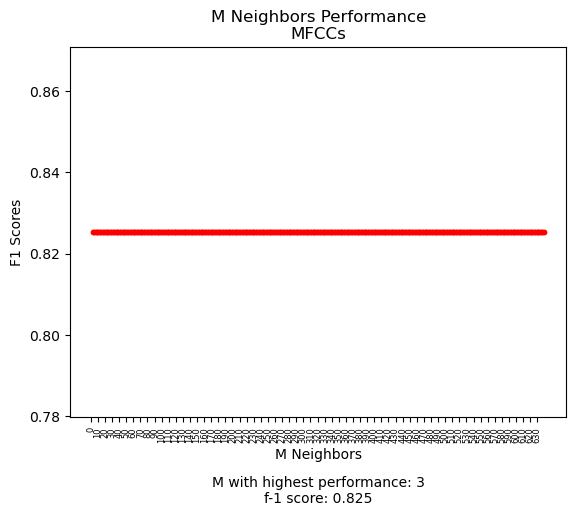


F1_score: 0.825


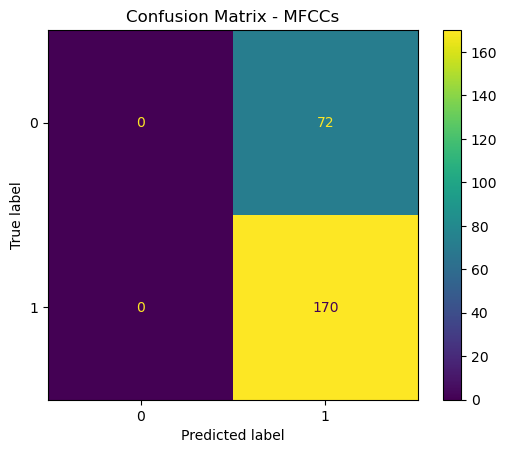

In [36]:
# Create train data

X_train_mfcc = []
y_train_mfcc = []

for row in df_train_mfcc.values:
    
    flattened_row = np.concatenate([item.flatten() if isinstance(item, np.ndarray) else [item] for item in row[:-1]])

    X_train_mfcc.append(flattened_row[:-1])
    y_train_mfcc.append(row[-1])
    
label_encoder = LabelEncoder()
y_train_mfcc = 1 - label_encoder.fit_transform(y_train_mfcc)


# Create test data

X_test_mfcc = []
y_test_mfcc = []

for row in df_test_mfcc.values:
    
    flattened_row = np.concatenate([item.flatten() if isinstance(item, np.ndarray) else [item] for item in row[:-1]])

    X_test_mfcc.append(flattened_row[:-1])
    y_test_mfcc.append(row[-1])
    
label_encoder = LabelEncoder()
y_test_mfcc = 1 - label_encoder.fit_transform(y_test_mfcc)

# Define the model

M = 3 # Initial value of M
max_M = len(y_train_mfcc)

m_values = []
f1_scores_mfcc = []

while M < max_M:
    classifier_mfcc = KNeighborsClassifier(M, p=2, metric='euclidean')
    classifier_mfcc.fit(X_train_mfcc, y_train_mfcc)

    # Predict the test set results

    y_pred_mfcc = classifier_mfcc.predict(X_test_mfcc)

    # F1 score
    f1 = f1_score(y_test_mfcc, y_pred_mfcc, pos_label=1)
    
    m_values.append(M)
    f1_scores_mfcc.append(f1)

    M += 2
    
index = f1_scores_mfcc.index(np.max(f1_scores_mfcc))
best_m_value = m_values[index]

plt.plot(m_values, f1_scores_mfcc)
plt.xlabel('M Neighbors')
plt.ylabel('F1 Scores')
plt.title('M Neighbors Performance\nMFCCs')
plt.xticks(np.arange(0, max_M, step=10), rotation=90, fontsize=6) 

for m, f1 in zip(m_values, f1_scores_mfcc):   
    plt.scatter(m, f1, marker='o', color='red', s=10, zorder=5)

plt.text(0.5, -0.2, 'M with highest performance: ' + str(best_m_value) + "\nf-1 score: " + str(round(np.max(f1_scores_mfcc),3)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

# Evaluate Model

classifier_mfcc = KNeighborsClassifier(n_neighbors=best_m_value, p=2, metric='euclidean')
classifier_mfcc.fit(X_train_mfcc, y_train_mfcc)

# Predict the test set results

y_pred_mfcc = classifier_mfcc.predict(X_test_mfcc)


cm_mfcc = confusion_matrix(y_test_mfcc, y_pred_mfcc)
f1_mfcc = f1_score(y_test_mfcc, y_pred_mfcc, pos_label=1)
print("\nF1_score: " + str(round(f1_mfcc,3)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_mfcc, display_labels=classifier_mfcc.classes_)
disp.plot()
plt.title("Confusion Matrix - MFCCs")
plt.show()


## KNN MFCCs and Percentiles

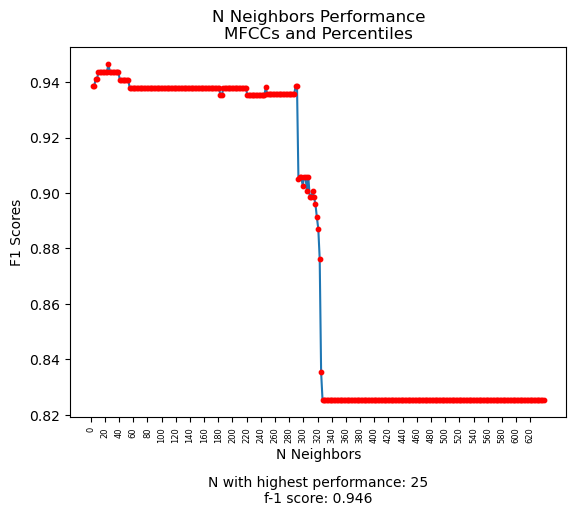


F1_score: 0.946


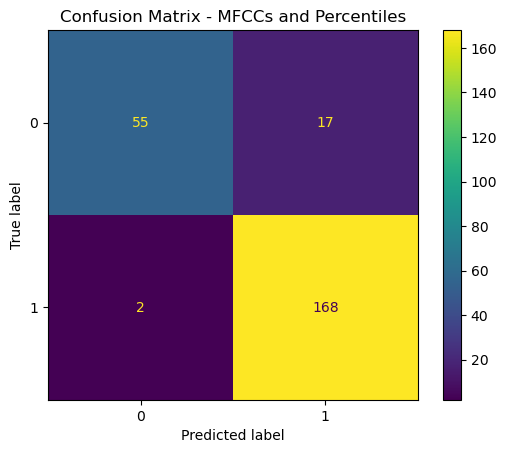

In [26]:
# Create train data

X_train_combined = []
y_train_combined = []

for row in df_train_combined.values:
    
    flattened_row = np.concatenate([item.flatten() if isinstance(item, np.ndarray) else [item] for item in row[:-1]])

    X_train_combined.append(flattened_row[:-1])
    y_train_combined.append(row[-1])
    
label_encoder = LabelEncoder()
y_train_combined = 1 - label_encoder.fit_transform(y_train_combined)


# Create test data

X_test_combined = []
y_test_combined = []

for row in df_test_combined.values:
    
    flattened_row = np.concatenate([item.flatten() if isinstance(item, np.ndarray) else [item] for item in row[:-1]])

    X_test_combined.append(flattened_row[:-1])
    y_test_combined.append(row[-1])
    
label_encoder = LabelEncoder()
y_test_combined = 1 - label_encoder.fit_transform(y_test_combined)


# Define the model

N = 3 # Initial value of N
max_N = len(y_train_combined)

n_values = []
f1_scores_combined = []

while N < max_N:
    classifier_combined = KNeighborsClassifier(N, p=2, metric='euclidean')
    classifier_combined.fit(X_train_combined, y_train_combined)

    # Predict the test set results

    y_pred_combined = classifier_combined.predict(X_test_combined)

    # F1 score
    f1 = f1_score(y_test_combined, y_pred_combined, pos_label=1)
    
    n_values.append(N)
    f1_scores_combined.append(f1)

    N += 2
    
index = f1_scores_combined.index(np.max(f1_scores_combined))
best_n_value = n_values[index]

plt.plot(n_values, f1_scores_combined)
plt.xlabel('N Neighbors')
plt.ylabel('F1 Scores')
plt.title('N Neighbors Performance\nMFCCs and Percentiles')
plt.xticks(np.arange(0, max_N, step=20), rotation=90, fontsize=6) 

for n, f1 in zip(n_values, f1_scores_combined):   
    plt.scatter(n, f1, marker='o', color='red', s=10, zorder=5)

plt.text(0.5, -0.2, 'N with highest performance: ' + str(best_n_value) + "\nf-1 score: " + str(round(np.max(f1_scores_combined),3)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

# Evaluate Model

classifier_combined = KNeighborsClassifier(n_neighbors=best_n_value, p=2, metric='euclidean')
classifier_combined.fit(X_train_combined, y_train_combined)

# Predict the test set results

y_pred_combined = classifier_combined.predict(X_test_combined)


cm_combined = confusion_matrix(y_test_combined, y_pred_combined)
f1_combined = f1_score(y_test_combined, y_pred_combined, pos_label=1)
print("\nF1_score: " + str(round(f1_combined,3)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_combined, display_labels=classifier_combined.classes_)
disp.plot()
plt.title("Confusion Matrix - MFCCs and Percentiles")
plt.show()


# Support Vector Machine

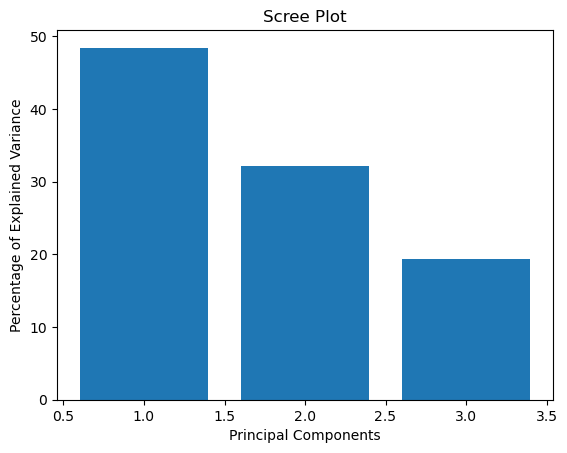

        var   PC
0  0.484455  PC1
1  0.321992  PC2
2  0.193553  PC3


In [27]:
# Support Vector Machine Data Preparation - Percentiles
# PCA: Principle Component Analysis
# For combining 4 features into 2 orthogonal meta-features

pca = PCA()

X_train_pca_per = pca.fit_transform(X_train_per)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    top=False,)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')

plt.show()

df_sns = pd. DataFrame({ 'var':pca.explained_variance_ratio_,
'PC' : ['PC1', 'PC2', 'PC3']})

print(df_sns.head())
        

In [28]:
# Train pc1 and pc2 coords
train_pc1_coords = X_train_pca_per[:, 0] # x-axis coordinates of the data after PCA (PC1)
train_pc2_coords = X_train_pca_per[:, 1] # y-axis coordinates of the data after PCA (PC2)

pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# Optimizing the SVM fit to the x and y-axis coordinates after PCA dimension reduction
param_grid = [
    {
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
    },
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train_per)

print(optimal_params.best_params_)

# Optimal parameters may be different than the old ones

{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}


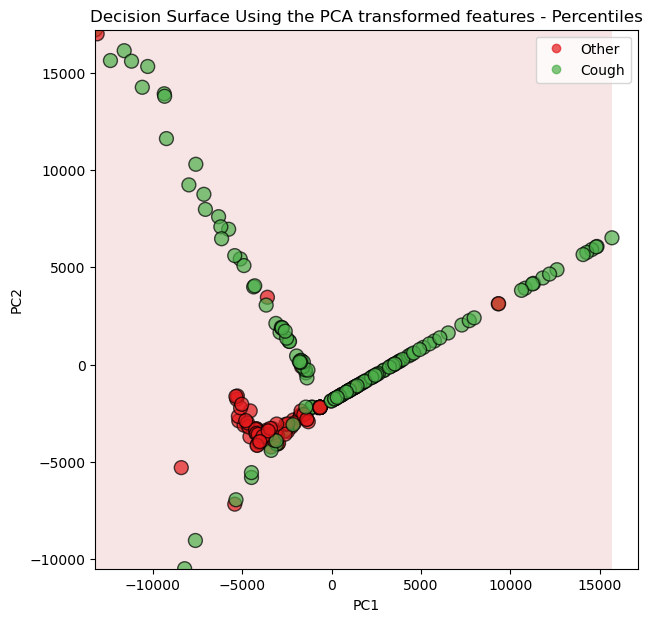

In [30]:
from matplotlib.colors import ListedColormap 

# Prediction
clf_svm_per= SVC(random_state=42, C=100, gamma=1)
clf_svm_per.fit(pca_train_scaled, y_train_per)

# Extraction of PC1 and PC2 for test data
X_test_pca = pca.transform(X_test_per)
test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

# Determining the graph boundaries
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

# Determining the graph boundaries
step_size = 5  # Adjust the step size as needed
xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=step_size),
                     np.arange(start=y_min, stop=y_max, step=step_size))


# Classify every point in the matrix with the SVM
# Points on one side 1, point on other side 0 
Z = clf_svm_per.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)

Z = np.array(Z)



# Plot the decision boundary and scatter plot of data points
cmap = ListedColormap(['#e41a1c', '#4daf4a'])
fig, ax = plt.subplots(figsize=(7,7))
ax.contourf(xx, yy, Z, alpha=0.1)

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_test_per, cmap=cmap, s=100, edgecolors='k', alpha=0.7)
legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                  loc="upper right")

legend.get_texts()[0].set_text('Other')
legend.get_texts()[1].set_text('Cough')

ax.set_ylabel("PC2")
ax.set_xlabel("PC1")
ax.set_title("Decision Surface Using the PCA transformed features - Percentiles")
plt.show()

Kernel used by the SVM: rbf


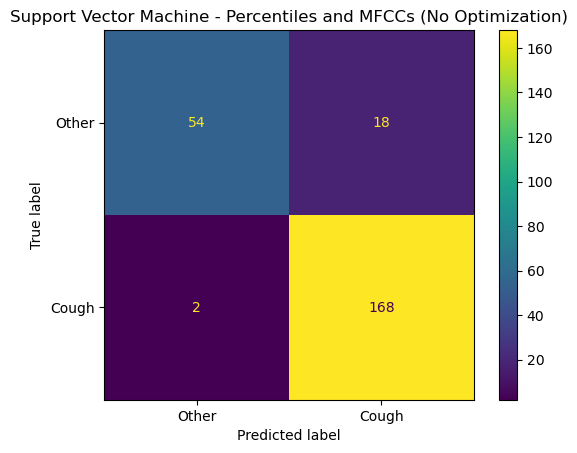

In [37]:
# Support Vector Machine

clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_combined, y_train_combined)
print("Kernel used by the SVM:", clf_svm.kernel)

y_pred_svm = clf_svm.predict(X_test_combined)
cm_svm = confusion_matrix(y_test_combined, y_pred_svm)

custom_labels = ['Other', 'Cough']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=custom_labels)
disp.plot()
plt.title("Support Vector Machine - Percentiles and MFCCs (No Optimization)")
plt.show()

In [38]:
# Optimize the parameters
# Finding the best value for gamma and regularization parameter

# C: regularization parameter
param_grid = [
    {
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
    },
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(X_train_combined, y_train_combined)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


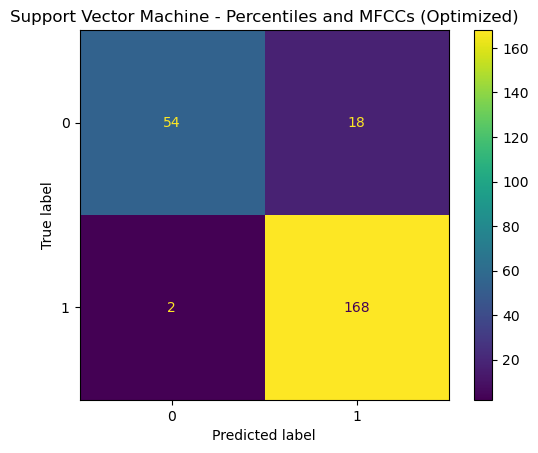

In [41]:
# Final Support Vector Machine

clf_svm_2 = SVC(random_state=42, C=10, gamma='scale', kernel='rbf')
clf_svm_2.fit(X_train_combined, y_train_combined)

# Plot Confusion Matrix

y_pred_svm_2 = clf_svm_2.predict(X_test_combined)
cm_svm_2 = confusion_matrix(y_test_combined, y_pred_svm_2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_2)
disp.plot()
plt.title("Support Vector Machine - Percentiles and MFCCs (Optimized)")
plt.show()